The notebook updates error arrays for 1D and 2D extracted spectra (x1d and s2d products) from Poisson and read noise variance extensions. Use this workaround until reference flat files are delivered with associated error estimates.

In [1]:
import requests

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits

import warnings
warnings.simplefilter('ignore', RuntimeWarning)

Define a function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [2]:
def get_jwst_file(name, mast_api_token=None):
    """Retrieve a JWST data file from MAST archive."""
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Create a list of filenames. Download the data from MAST.

In [3]:
x1d_names = []
s2d_names = []
for activity in [2]:
    for exposure in [1]:
        for detector in [1, 2]:
            x1d_names.append(f'jw02288003001_041{activity:02}_{exposure:05}_nrs{detector}_x1d.fits')
            s2d_names.append(f'jw02288003001_041{activity:02}_{exposure:05}_nrs{detector}_s2d.fits')

for name in x1d_names + s2d_names:
    print(f'Downloading {name}')
    get_jwst_file(name)

For the extracted spectrum, error information is stored in table columns.  The overall error on the flux is reported in the FLUX_ERROR column.  For some versions of the pipeline and NIRSpec flat reference files, the FLUX_ERROR may be erroneously filled with NaN values.

The error on the flux may be recalculated from the component variance sources.  These are stored in the spectral columns FLUX_VAR_POISSON, FLUX_VAR_RNOISE, and FLUX_VAR_FLAT.  The FLUX_VAR_FLAT may be filled with zeroes or NaN values, for flat reference files that do not yet have associated error estimates.

Combine the three variance sources in quadrature and take the square root to estimate the error on the flux.

In [4]:
for name in x1d_names:
    with fits.open(name, 'update') as hdulist:
        print(f'Updating error for {name}')
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                print(f"Extension {extnum}")

                # report value before correction
                print(f"\tMean error before update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")

                # report input values
                print(f"\tMean Poisson error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_POISSON']))}")
                print(f"\tMean read noise error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_RNOISE']))}")
                print(f"\tMean flat error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_FLAT']))}\n")
                
                # add components in quadrature, ignoring NaNs
                components = [hdu.data['FLUX_VAR_POISSON'], 
                              hdu.data['FLUX_VAR_RNOISE'], 
                              hdu.data['FLUX_VAR_FLAT']]
                new_error = np.sqrt(np.nansum(components, axis=0))
                
                # update FITS file
                hdu.data['FLUX_ERROR'] = new_error

                # report value after correction
                print(f"\tMean error after update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")


Updating error for jw02288003001_04102_00001_nrs1_x1d.fits
Extension 1
	Mean error before update: nan

	Mean Poisson error: 2.74488444744571e-06
	Mean read noise error: 6.519693781338999e-06
	Mean flat error: nan

	Mean error after update: 6.52349805720756e-06

Extension 2
	Mean error before update: nan

	Mean Poisson error: 1.4888939319406317e-06
	Mean read noise error: 4.181562660391171e-06
	Mean flat error: nan

	Mean error after update: 4.047335422023989e-06

Extension 3
	Mean error before update: nan

	Mean Poisson error: 1.6047442075859378e-06
	Mean read noise error: 4.0789773541724915e-06
	Mean flat error: nan

	Mean error after update: 4.006317449216202e-06

Extension 4
	Mean error before update: nan

	Mean Poisson error: 2.082787159009374e-06
	Mean read noise error: 5.5868973767054705e-06
	Mean flat error: nan

	Mean error after update: 2.427379808337134e-06

Updating error for jw02288003001_04102_00001_nrs2_x1d.fits
Extension 1
	Mean error before update: nan

	Mean Poisson er

If the flat error has not been provided (i.e. the mean flat error is reported as zero or NaN, above), the calculated error may be underestimated for the spectrum.  If desired, an estimate of the systematic error due to flat correction can be added in place of the flat variance array.

For example, add a 1% overall error on the flux in place of the flat variance.

In [5]:
for name in x1d_names:
    with fits.open(name, 'update') as hdulist:
        print(f'Updating error for {name} with additional estimated flat error')
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                print(f"Extension {extnum}")

                # report value before correction
                print(f"\tMean error before update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")

                # report input values
                print(f"\tMean Poisson error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_POISSON']))}")
                print(f"\tMean read noise error: {np.sqrt(np.nanmean(hdu.data['FLUX_VAR_RNOISE']))}")

                # estimate a 1% flat error
                flat_var = (0.01 * hdu.data['FLUX']) ** 2
                print(f"\tMean estimated flat error: {np.sqrt(np.nanmean(flat_var))}\n")
                
                # add components in quadrature, ignoring NaNs
                components = [hdu.data['FLUX_VAR_POISSON'], 
                              hdu.data['FLUX_VAR_RNOISE'], 
                              flat_var]
                new_error = np.sqrt(np.nansum(components, axis=0))
                
                # update FITS file
                hdu.data['FLUX_ERROR'] = new_error

                # report value after correction
                print(f"\tMean error after update: {np.nanmean(hdu.data['FLUX_ERROR'])}\n")

Updating error for jw02288003001_04102_00001_nrs1_x1d.fits with additional estimated flat error
Extension 1
	Mean error before update: 6.52349805720756e-06

	Mean Poisson error: 2.74488444744571e-06
	Mean read noise error: 6.519693781338999e-06
	Mean estimated flat error: 1.3447302215278501e-07

	Mean error after update: 6.525147233766227e-06

Extension 2
	Mean error before update: 4.047335422023989e-06

	Mean Poisson error: 1.4888939319406317e-06
	Mean read noise error: 4.181562660391171e-06
	Mean estimated flat error: 6.110330031869775e-08

	Mean error after update: 4.048013750238812e-06

Extension 3
	Mean error before update: 4.006317449216202e-06

	Mean Poisson error: 1.6047442075859378e-06
	Mean read noise error: 4.0789773541724915e-06
	Mean estimated flat error: 6.67969665782592e-08

	Mean error after update: 4.0071934135385834e-06

Extension 4
	Mean error before update: 2.427379808337134e-06

	Mean Poisson error: 2.082787159009374e-06
	Mean read noise error: 5.5868973767054705e-

The 2D spectral files contain similar component variance information, stored in image extensions rather table columns. The error on the flux, in the ERR extension, generally was not impacted by the all-NaN propagation issue in the pipeline, but it may still be underestimated for some reference flat files.  An additional error may be added to these products in a similar manner.

Apply the same systematic 1% error to the s2d data products.

In [6]:
for name in s2d_names:
    with fits.open(name, 'update') as hdulist:
        print(f'Updating error for {name} with additional estimated flat error')
        spectral_set = 0
        flux, error_extnum, var_p, var_r = None, None, None, None
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'SCI':
                # SCI extension marks the start of a new spectral set
                spectral_set += 1
                
                # keep the flux from the SCI extension
                flux = hdu.data
            elif hdu.name == 'ERR':
                # keep the ERR extension number, to update later
                error_extnum = extnum
            elif hdu.name == 'VAR_POISSON':
                # keep the poisson variance
                var_p = hdu.data
            elif hdu.name == 'VAR_RNOISE':
                # keep the read noise variance
                var_r = hdu.data
            elif hdu.name == 'VAR_FLAT':
                # ignore the input flat variance, update the error extension for the set
                print(f"Spectral set {spectral_set}")
                
                # report value before correction
                print(f"\tMean error before update: {np.nanmean(hdulist[error_extnum].data)}\n")

                # report input values
                print(f"\tMean Poisson error: {np.sqrt(np.nanmean(var_p))}")
                print(f"\tMean read noise error: {np.sqrt(np.nanmean(var_r))}")

                # estimate a 1% flat error
                flat_var = (0.01 * flux) ** 2
                print(f"\tMean estimated flat error: {np.sqrt(np.nanmean(flat_var))}\n")
                
                # add components in quadrature, ignoring NaNs
                components = [var_p, var_r, flat_var] 
                new_error = np.sqrt(np.nansum(components, axis=0))
                
                # update FITS file
                hdulist[error_extnum].data = new_error

                # report value after correction
                print(f"\tMean error after update: {np.nanmean(hdulist[error_extnum].data)}\n")

Updating error for jw02288003001_04102_00001_nrs1_s2d.fits with additional estimated flat error
Spectral set 1
	Mean error before update: 3.725724156272703e-12

	Mean Poisson error: 4.265953475884876e-12
	Mean read noise error: 3.348140775044639e-12
	Mean estimated flat error: 2.9398814112291394e-12

	Mean error after update: 4.1938943637354065e-12

Spectral set 2
	Mean error before update: 4.266389846801758

	Mean Poisson error: 2.484879732131958
	Mean read noise error: 6.413130283355713
	Mean estimated flat error: 0.05487721040844917

	Mean error after update: 4.266573905944824

Spectral set 3
	Mean error before update: 2.2124338150024414

	Mean Poisson error: 3.4569361209869385
	Mean read noise error: 4.117454528808594
	Mean estimated flat error: 0.03416188806295395

	Mean error after update: 2.2125301361083984

Spectral set 4
	Mean error before update: 0.4937143921852112

	Mean Poisson error: 0.9264145493507385
	Mean read noise error: 0.7106173038482666
	Mean estimated flat error: 

Both 1D and 2D spectral data should now have appropriate errors.

Plot the 1D spectra with errors marked as a shaded range around the flux.

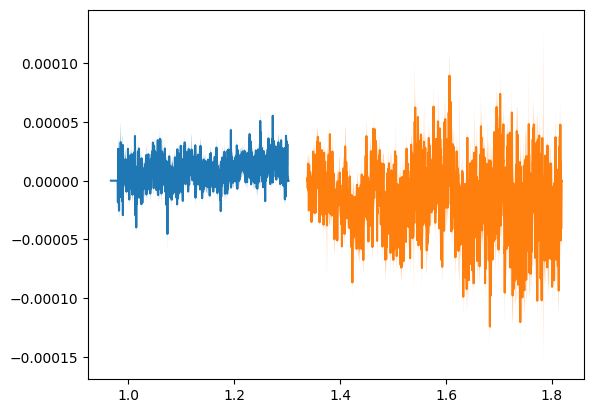

In [7]:
for i, name in enumerate(x1d_names):
    with fits.open(name) as hdulist:
        data = hdulist['extract1d'].data
        line2d = plt.plot(data['WAVELENGTH'], data['FLUX'])
        error_range = plt.fill_between(data['WAVELENGTH'], 
                                       data['FLUX'] - data['FLUX_ERROR'], 
                                       data['FLUX'] + data['FLUX_ERROR'])